### HMM Software
- [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html)
- [pomegranite]()
- [r calculate AIC/BIC of model](https://rdrr.io/cran/HMMpa/man/AIC_HMM.html)
- [comparison between pomegranite and hmmlearn (with notebook)](https://kyso.io/share/pomegranate-vs-hmmlearn#files)
- [discussion of AIC/BIC from hmmlearn](https://waterprogramming.wordpress.com/2018/07/03/fitting-hidden-markov-models-part-ii-sample-python-script/)

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

### Collect data

In [6]:
DATASET_ID = 'bengalese_finch_sober'

In [7]:
DATA_DIR

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data')

In [8]:
syllable_df = pd.concat([pd.read_pickle(i) for i in list((DATA_DIR / 'indv_dfs' / DATASET_ID).glob('*.pickle'))])

In [9]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,key,rate,spectrogram,syllables_sequence_id,syllables_sequence_pos,umap,hdbscan_labels
0,1.806375,1.828219,-,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_190612_0...,32000,"[[4, 4, 4, 4, 4, 4, 4, 3, 14, 9, 30, 85, 64, 4...",0,0,"[-1.51081, 4.8511953]",5
1,2.173500,2.225844,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_190612_0...,32000,"[[5, 5, 5, 4, 5, 6, 4, 5, 6, 4, 5, 5, 5, 5, 5,...",0,1,"[-0.06860913, 4.332588]",5
2,2.482687,2.550906,i,gr41rd51,0,gr41rd51__3part_SYLc_th4191_belowhits_190612_0...,32000,"[[7, 7, 7, 6, 33, 79, 68, 50, 66, 84, 53, 54, ...",0,2,"[2.1000683, 4.4189005]",5


In [10]:
label = "hdbscan_labels"

#### Compare hdbscan to hand

In [11]:
from avgn.visualization.projections import scatter_spec, scatter_projections
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [12]:
indvs = syllable_df.indv.unique()

In [13]:
label_dict = {lab:i for i, lab in enumerate(np.unique(syllable_df['labels'].values))}
syllable_df['labels_num'] = [label_dict[i] for i in syllable_df.labels.values]

gr41rd51


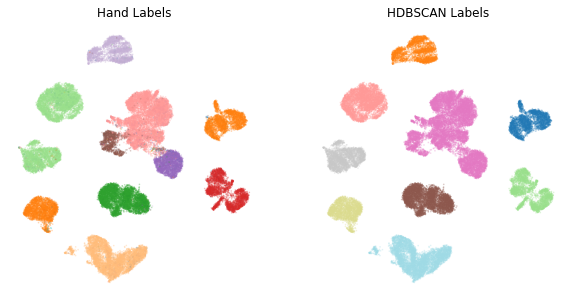

or60yw70


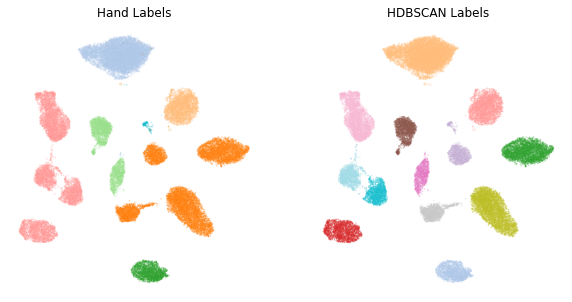

gy6or6


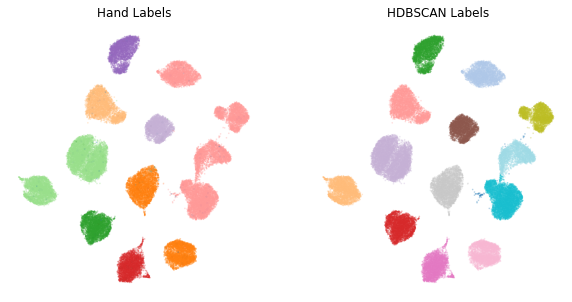

bl26lb16


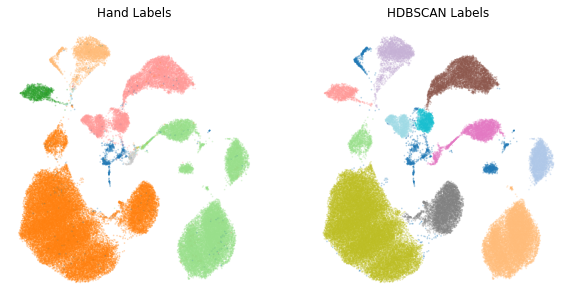

In [14]:
for indv in tqdm(indvs):
    print(indv)
    indv_df = syllable_df[syllable_df.indv == indv]
    z = np.vstack(indv_df.umap.values)
    
    fig, axs = plt.subplots(ncols=2, figsize=(10,5))
    ax = axs[0]
    ax.scatter(z[:,0], z[:,1], c = indv_df['labels_num'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
    ax.axis('off')
    ax.set_title('Hand Labels')
    ax = axs[1]
    ax.scatter(z[:,0], z[:,1], c = indv_df['hdbscan_labels'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
    ax.set_title('HDBSCAN Labels')
    ax.axis('off')
    plt.show()

### train FOMM on data

In [15]:
indv = 'or60yw70'
indv_df = syllable_df[syllable_df.indv == indv]
indv_df = indv_df.sort_values(by=['syllables_sequence_id', 'syllables_sequence_pos'])
indv_df = indv_df.reset_index()
print(len(indv_df))
indv_df[:3]

35799


,index,start_time,end_time,labels,indv,indvi,key,rate,spectrogram,syllables_sequence_id,syllables_sequence_pos,umap,hdbscan_labels,labels_num
0,0,9.029750,9.090969,i,or60yw70,0,or60yw70_011012_0724.503,32000,"[[8, 8, 8, 8, 10, 8, 56, 117, 118, 90, 71, 64,...",0,0,"[-9.551727, 2.7543738]",8,11
1,1,9.195656,9.267406,i,or60yw70,0,or60yw70_011012_0724.503,32000,"[[1, 1, 1, 1, 0, 11, 59, 70, 91, 68, 74, 48, 3...",0,1,"[-9.808033, 2.5435884]",8,11
2,2,9.321281,9.381656,a,or60yw70,0,or60yw70_011012_0724.503,32000,"[[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, ...",0,2,"[-0.17588094, 10.46355]",1,3


In [16]:
# remove low probability elements
element_prob = {i: np.sum(indv_df.labels_num.values== i) for i in np.unique(indv_df.labels_num.values)}
for key, val in element_prob.items():
    if val < 100:
        indv_df = indv_df.drop(indv_df[indv_df.labels_num == key].index)
len(indv_df)

35771

In [17]:
hand_seqs = [
    list(indv_df[indv_df.syllables_sequence_id == seqid]["labels_num"].values)
    for seqid in indv_df.syllables_sequence_id.unique()
]
print(hand_seqs[:3])

[[11, 11, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 11, 11, 5, 6, 7, 8, 11, 5, 6, 7, 8, 11, 5, 6, 9, 11, 3, 3, 3, 3, 4, 4, 4, 4, 11, 11, 5, 6, 7, 8, 11, 5, 6, 9, 11, 3, 3, 3, 3, 4, 4, 4, 4, 4, 11, 11, 5, 6, 7, 8, 11, 5, 6, 9, 11, 3, 3, 3, 3, 4, 4, 4, 4, 4, 11, 11, 5, 6, 7, 8, 11, 5, 11, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 11, 11, 5, 6, 7, 8, 11, 5, 6, 9], [11, 11, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4], [11, 11, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]]


In [18]:
from hmmlearn import hmm

In [19]:
def AIC(log_likelihood, k):
    """ AIC given log_likelihood and # parameters (k)
    """
    aic = 2 * k - 2 * log_likelihood
    return aic


def BIC(log_likelihood, n, k):
    """ BIC given log_likelihood, number of observations (n) and # parameters (k)
    """
    bic = np.log(n) * k - 2 * log_likelihood
    return bic

In [147]:
def FOMM(seqs, prop_test=0.5):

    if prop_test == 0:
        seqs_train = seqs_test = seqs
    else: 
        # split into train and test for cross validation
        training_mask = np.random.choice(np.arange(len(seqs)), size = int(len(seqs)*prop_test), replace=False)
        testing_mask = np.array([i for i in np.arange(len(seqs)) if i not in training_mask])

        seqs_train  = np.array(seqs)[training_mask]
        seqs_test  = np.array(seqs)[testing_mask]

        # make sure test set doesn't contain any data that train doesnt
        assert np.all(
            [
                i in np.unique(np.concatenate(seqs_train))
                for i in np.unique(np.concatenate(seqs_test))
            ]
        )

    # lengths of sequences
    seq_lens = [len(i) for i in seqs_train]

    # get states
    unique_states = np.unique(np.concatenate(seqs_train))
    lab_dict = {lab: i for i, lab in enumerate(unique_states)}
    lab_list = [[key, val] for key, val in lab_dict.items()]

    # convert seqs to numbers
    seqs_num = [[lab_dict[i] for i in seq] for seq in seqs_train]
    unique_states_num = np.unique(np.concatenate(seqs_num))

    # get start probabilities
    seq_starts = np.array([i[0] for i in seqs_num])
    start_probs = [np.sum(seq_starts == i) / len(seqs_train) for i in unique_states_num]

    # transition probs
    trans_mat = np.zeros((len(unique_states_num), len(unique_states_num)))
    for seq in seqs_num:
        for i, j in zip(seq[:-1], seq[1:]):
            trans_mat[i, j] += 1
    # smooth to nonzero probabilities
    trans_mat = (trans_mat.T / trans_mat.sum(axis=1)).T  # np.sum(trans_mat, axis=1)
    
    # smooth emissions
    emission_prob = np.identity(len(unique_states)) + 1e-5
    emission_prob = (emission_prob.T / emission_prob.sum(axis=1)).T  
    
    # create model
    model = hmm.MultinomialHMM(n_components=len(unique_states))
    model.startprob_ = start_probs
    model.transmat_ = trans_mat
    model.emissionprob_ = emission_prob

    # test sequence
    test_seqs_num = [[lab_dict[i] for i in seq] for seq in seqs_test]
    test_seq_lens = [len(i) for i in test_seqs_num]
    
    #breakme
    
    # compute log probability
    log_probability = model.score(
        np.concatenate(test_seqs_num).reshape(-1, 1), [len(i) for i in test_seqs_num]
    )

    # number of datapoints
    n_data = np.sum(test_seq_lens)

    # number of params in model
    num_params = (
        np.product(model.transmat_.shape)
        + np.product(model.emissionprob_.shape)
        + np.product(model.startprob_.shape)
    )

    # AIC and BIC
    aic = AIC(log_probability, num_params)
    bic = BIC(log_probability, n_data, num_params)
    return model, log_probability, aic, bic, lab_dict

In [148]:
n_repeats = 10
results = Parallel(n_jobs=1, verbose=15)(
    delayed(FOMM)(hand_seqs, prop_test=0.5)
    for n_components in tqdm(range(n_repeats))
)
results_df_FOMM = pd.DataFrame(results, 
    columns=["model", "log_probability", "AIC", "BIC", "lab_dict"]
)
results_df_FOMM[:3]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


,model,log_probability,AIC,BIC,lab_dict
0,"MultinomialHMM(algorithm='viterbi', init_param...",-9739.322636,19820.645272,21148.367136,"{3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 11:..."
1,"MultinomialHMM(algorithm='viterbi', init_param...",-10058.580622,20459.161243,21790.816771,"{3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 11:..."
2,"MultinomialHMM(algorithm='viterbi', init_param...",-10342.139341,21026.278681,22362.892998,"{3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 11:..."


In [149]:
model, log_probability, aic, bic, lab_dict = results_df_FOMM.iloc[0]

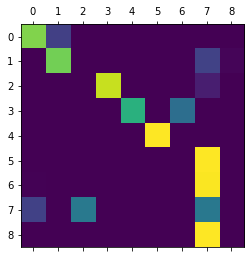

In [150]:
plt.matshow(model.transmat_)

In [151]:
print(np.concatenate(model.sample(100)[0]))

[7 2 3 6 7 2 3 4 5 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 7 2 3 4 5 7 0 0 0
 0 1 7 2 3 4 5 7 7 0 0 0 0 0 0 0 0 1 1 7 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 7
 7 2 3 6 7 7 2 3 6 7 7 7 2 7 7 2 3 4 5 7 2 3 4 5 7 7]


In [152]:
print(aic, bic, log_probability)

19820.645272034308 21148.367135831046 -9739.322636017154


### Fit HMM

In [153]:
def fit_hmm(seqs, n_components, prop_test = 0.5):
    
    # split into train and test for cross validation
    training_mask = np.random.choice(np.arange(len(seqs)), size = int(len(seqs)*prop_test), replace=False)
    testing_mask = np.array([i for i in np.arange(len(seqs)) if i not in training_mask])

    seqs_train = np.array(seqs)[training_mask]
    seqs_test = np.array(seqs)[testing_mask]
    
    # get states
    unique_states = np.unique(np.concatenate(seqs_train))
    lab_dict = {lab: i for i, lab in enumerate(unique_states)}
    lab_list = [[key, val] for key, val in lab_dict.items()]

    # convert seqs to numbers
    seqs_num = [[lab_dict[i] for i in seq] for seq in seqs_train]
    unique_states_num = np.unique(np.concatenate(seqs_num))
    
    
    # model
    model = hmm.MultinomialHMM(n_components=n_components).fit(
        np.concatenate(seqs_num).reshape(-1, 1), [len(i) for i in seqs_train]
    )
    
    # params
    num_params = (
        np.product(model.transmat_.shape)
        + np.product(model.emissionprob_.shape)
        + np.product(model.startprob_.shape)
    )
    
    # test sequence
    test_seqs_num = [[lab_dict[i] for i in seq] for seq in seqs_test]
    n_data = np.sum([len(i) for i in test_seqs_num])
    
    # probability of data given model
    log_probability = model.score(
                np.concatenate(test_seqs_num).reshape(-1, 1), [len(i) for i in test_seqs_num]
    )
    
    # AIC and BIC
    aic = AIC(log_probability, num_params)
    bic = BIC(log_probability, n_data, num_params)
    return (model,
        n_components,
        num_params,
        log_probability,
        aic,
        bic)

In [154]:
n_repeats = 10
results = Parallel(n_jobs=-1, verbose=15)(
    delayed(fit_hmm)(hand_seqs, n_components)
    for n_components in tqdm(np.random.permutation(np.repeat(np.arange(15, 60, 5), n_repeats)))
)
results_df = pd.DataFrame(results, 
    columns=["model", "n_components", "n_params", "log_prob", "AIC", "BIC"]
)
results_df[:3]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

,model,n_components,n_params,log_prob,AIC,BIC
0,"MultinomialHMM(algorithm='viterbi', init_param...",20,600,-7958.281761,17116.563523,21786.540743
1,"MultinomialHMM(algorithm='viterbi', init_param...",30,1200,-10437.628440,23275.256880,32657.033887
2,"MultinomialHMM(algorithm='viterbi', init_param...",30,1200,-9800.131381,22000.262762,31366.385942


In [155]:
model, n_components, n_params, log_prob, aic, bic = results_df.iloc[np.argmax(results_df.BIC.values)] 

In [156]:
print(np.concatenate(model.sample(100)[0]))

[7 2 3 4 5 7 0 0 0 1 1 1 1 7 2 3 6 5 7 2 3 4 5 7 2 3 6 7 7 0 0 0 0 0 1 1 1
 1 1 7 7 7 0 0 1 7 2 3 6 7 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 7 7 7 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 7 7 7 7 0 0 1 1 1 1 1 1 7 7 2 7]


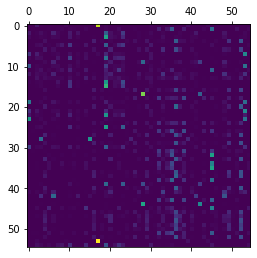

In [157]:
plt.matshow(model.transmat_)

### plot results

In [158]:
import seaborn as sns

Text(0.5, 1.0, 'BIC')

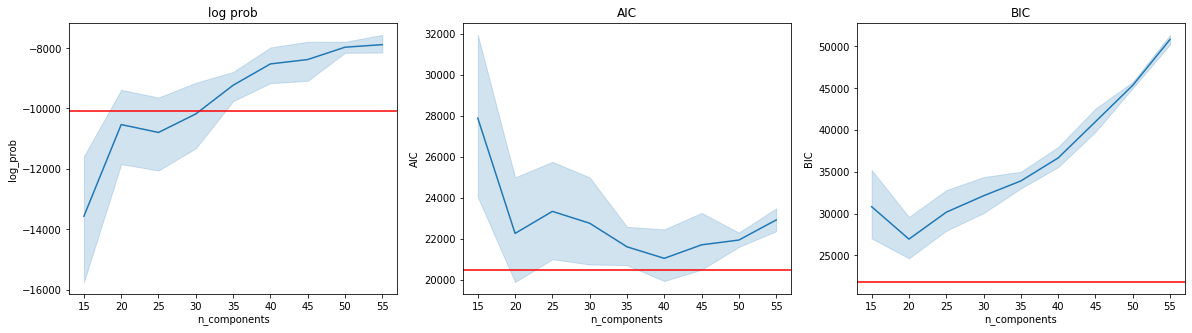

In [159]:
fig, axs = plt.subplots(ncols =3, figsize=(20,5))
ax = axs[0]
sns.lineplot(x = "n_components", y = "log_prob",data=results_df, ax = ax)
#ax.scatter(results_df.n_components, results_df.log_prob)
#ax.plot(results_df.n_components, results_df.log_prob)
ax.axhline(np.mean(results_df_FOMM.log_probability.values), color='red')
ax.set_title('log prob')

ax = axs[1]
#ax.scatter(results_df.n_components, results_df.AIC)
sns.lineplot(x = "n_components", y = "AIC", data=results_df, ax = ax)
#ax.plot(results_df.n_components, results_df.AIC)
ax.set_title('AIC')
ax.axhline(np.mean(results_df_FOMM.AIC.values), color='red')

ax = axs[2]
#ax.scatter(results_df.n_components, results_df.BIC)
sns.lineplot(x = "n_components", y = "BIC",  data=results_df, ax = ax)
#ax.plot(results_df.n_components, results_df.BIC)
ax.axhline(np.mean(results_df_FOMM.BIC.values), color='red')

ax.set_title('BIC')

### choose best HMM based on BIC, compare to FOMM

In [160]:
BIC_df = results_df[['n_components', 'BIC']].groupby('n_components').describe()
BIC_df.T

n_components            15            20            25            30  \
BIC count        10.000000     10.000000     10.000000     10.000000   
    mean      30811.705515  26939.576612  30155.415591  32121.501097   
    std        7098.718105   4207.505269   4235.834099   3756.522339   
    min       23530.015858  21786.540743  25009.899073  27720.305517   
    25%       25008.483577  23610.731412  27284.328871  29206.398339   
    50%       28926.352824  26982.739121  28166.534468  30931.479324   
    75%       36696.463681  29476.388477  32648.228916  35469.456488   
    max       42466.400945  35329.599893  38620.695478  37849.348646   

n_components            35            40            45            50  \
BIC count        10.000000     10.000000     10.000000     10.000000   
    mean      33894.391937  36643.853956  40974.747434  45325.213090   
    std        1645.543396   2067.350130   2316.810869    614.988540   
    min       31675.223176  33916.420091  38496.951851  44575.653613   
    25%       33127.873320  35812.245407  39489.698869  44989.369790   
    50%       33802.867541  36124.539534  40338.227131  45052.797410   
    75%       34130.917497  36830.112281  41656.760949  45739.362366   
    max       37683.787218  41170.822350  46400.948461  46375.537471   

n_components            55  
BIC count        10.000000  
    mean      50808.233090  
    std        1015.190184  
    min       48485.888136  
    25%       50629.907022  
    50%       50763.959598  
    75%       51080.138480  
    max       52527.531737

In [161]:
n_comp = BIC_df['BIC']['mean'].argmin()
BIC_mean = BIC_df['BIC']['mean'].min()
BIC_std = BIC_df.loc[n_comp]['BIC']['std']

n_comp, BIC_mean, BIC_std

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


(20, 26939.576612449287, 4207.505269181362)

In [162]:
np.mean(results_df_FOMM.BIC), np.std(results_df_FOMM.BIC)

(21809.50982582203, 424.32757639501324)

### color by HMM states

In [163]:
# convert seqs to numbers
seqs_num = [[lab_dict[i] for i in seq] for seq in hand_seqs]
unique_states_num = np.unique(np.concatenate(seqs_num))
unique_states_num

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

[7 2 7 7 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 7 7 2 3 4 7 0 0 0 0 0 0 0 0 1 1 1
 1 7 7 2 3 4 5 7 2 3 4 5 7 2 3 6 7 0 0 0 0 0 0 1 7 7 2 3 6 7 0 0 1 7 7 2 3
 7 7 0 0 0 0 0 0 0 0 0 1 1 1 1 5 7 2 3 4 7 0 0 0 0 0]


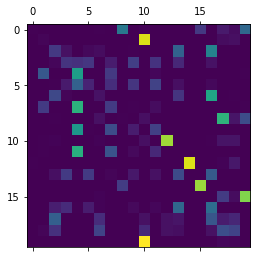

In [180]:
model, n_components, n_params, log_prob, aic, bic = results_df.iloc[np.argmin(results_df.BIC.values)] 
model, n_components, n_params, log_prob, aic, bic = results_df.iloc[np.argmin(results_df.AIC.values)] 
#model, n_components, n_params, log_prob, aic, bic = results_df.iloc[np.argmax(results_df.log_prob.values)] 

print(np.concatenate(model.sample(100)[0]))

plt.matshow(model.transmat_)

In [181]:
np.min(model.transmat_.flatten())

8.95503035745752e-23

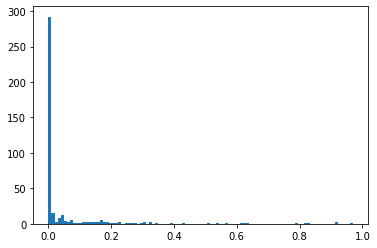

In [182]:
plt.hist(model.transmat_.flatten(), bins=100);

In [183]:
predictions = np.concatenate([model.predict(np.array(seq).reshape(-1, 1)) for seq in seqs_num])
len(predictions)

35771

In [184]:
np.unique(predictions)

array([ 1,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19])

In [185]:
indv_df[:3]

,index,start_time,end_time,labels,indv,indvi,key,rate,spectrogram,syllables_sequence_id,syllables_sequence_pos,umap,hdbscan_labels,labels_num
0,0,9.029750,9.090969,i,or60yw70,0,or60yw70_011012_0724.503,32000,"[[8, 8, 8, 8, 10, 8, 56, 117, 118, 90, 71, 64,...",0,0,"[-9.551727, 2.7543738]",8,11
1,1,9.195656,9.267406,i,or60yw70,0,or60yw70_011012_0724.503,32000,"[[1, 1, 1, 1, 0, 11, 59, 70, 91, 68, 74, 48, 3...",0,1,"[-9.808033, 2.5435884]",8,11
2,2,9.321281,9.381656,a,or60yw70,0,or60yw70_011012_0724.503,32000,"[[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, ...",0,2,"[-0.17588094, 10.46355]",1,3


In [186]:
z = np.vstack(indv_df.umap.values)

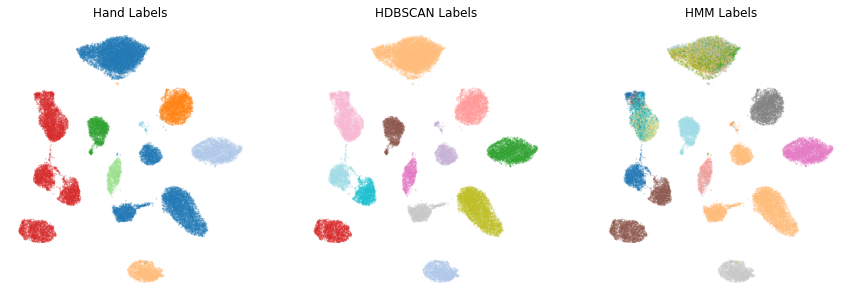

In [187]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
ax = axs[0]
ax.scatter(z[:,0], z[:,1], c = indv_df['labels_num'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.axis('off')
ax.set_title('Hand Labels')
ax = axs[1]
ax.scatter(z[:,0], z[:,1], c = indv_df['hdbscan_labels'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.set_title('HDBSCAN Labels')
ax.axis('off')

ax = axs[2]
ax.scatter(z[:,0], z[:,1], c = predictions, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.set_title('HMM Labels')
ax.axis('off')

plt.show()

In [ ]:
breakme

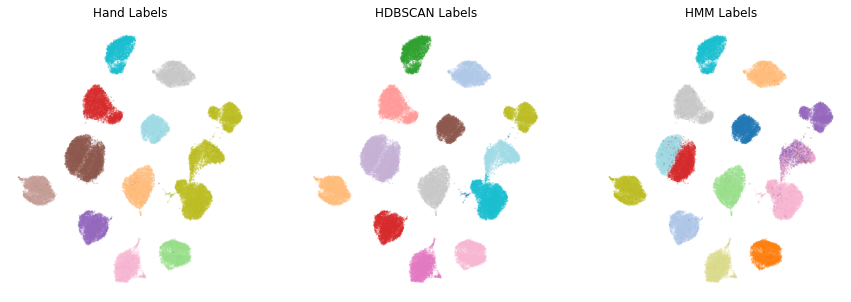

In [136]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
ax = axs[0]
ax.scatter(z[:,0], z[:,1], c = indv_df['labels_num'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.axis('off')
ax.set_title('Hand Labels')
ax = axs[1]
ax.scatter(z[:,0], z[:,1], c = indv_df['hdbscan_labels'].values, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.set_title('HDBSCAN Labels')
ax.axis('off')

ax = axs[2]
ax.scatter(z[:,0], z[:,1], c = predictions, s = 0.5, cmap = plt.cm.tab20, alpha = 0.25)
ax.set_title('HMM Labels')
ax.axis('off')

plt.show()

In [ ]:
### BIC number of params should be based on the number of actual edges...
# how does pomegranite determine this??

In [ ]:
### tomorr